In [29]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [7]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 32

# Training 수
epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

In [13]:
CurrentDirectory = "C:/Users/sosal/.jupyter/Lectures/CNN/"

train_directory = CurrentDirectory + 'TRAIN/'
test_directory  = CurrentDirectory + 'TEST/'
model_directory = CurrentDirectory + 'MODEL/'
tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [3]:
# VGG_16의 구현 2016?
def VGG_16():
    model = Sequential()
    # convolution / pooling의 반복
    model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #top layer of the VGG net
    return model

In [5]:
vggModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [67]:
# 모델 Return
VGGModel = tf.keras.applications.VGG16(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
# 마지막 prediction layer를 위한 작업

x = GlobalAveragePooling2D()(VGGModel.output)
predictions = Dense(1, activation='sigmoid')(x)

# Input ~ Output 연결해주기
DeepLearning = Model(inputs=VGGModel.input, outputs=predictions)

# learning parameter를 더하여 최종 model compile
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='binary_crossentropy',
         metrics=['acc']
) # 나이를, MSE

In [63]:
DeepLearning.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [18]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [23]:
# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "binary",
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode="binary",
    subset = "validation")

# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode='binary')

Found 486 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [24]:
# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath=model_directory+'NewModelVGG50-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# 학습과정 진행사항 확인
TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, TB, LR]

In [66]:
########## Training Start
DeepLearning.fit_generator(
        TRAIN_GENERATOR,
        # 데이터가 너무 클 경우 1-epoch을 못하는 경우
        #steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
        
        epochs=15,
        callbacks=CALLBACK,
        shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
        validation_data=VALID_GENERATOR)
###########

c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator spec

Epoch 1/15
16/16 [==============================] - 11s 480ms/step - loss: 0.6193 - acc: 0.6338 - val_loss: 0.7212 - val_acc: 0.5000

Epoch 00001: val_acc did not improve from 0.88889
Epoch 2/15
16/16 [==============================] - 6s 387ms/step - loss: 0.2951 - acc: 0.8972 - val_loss: 0.7404 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.88889
Epoch 3/15
16/16 [==============================] - 6s 385ms/step - loss: 0.1910 - acc: 0.9496 - val_loss: 0.7099 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.88889
Epoch 4/15
16/16 [==============================] - 6s 381ms/step - loss: 0.1548 - acc: 0.9576 - val_loss: 0.6970 - val_acc: 0.5000

Epoch 00004: val_acc did not improve from 0.88889
Epoch 5/15
16/16 [==============================] - 6s 385ms/step - loss: 0.1460 - acc: 0.9371 - val_loss: 0.7033 - val_acc: 0.5000

Epoch 00005: val_acc did not improve from 0.88889
Epoch 6/15
10/16 [=================>............] - ETA: 2s - loss: 0.1432 - acc: 0.

KeyboardInterrupt: 

In [68]:
# 학습하지 않았으므로, 강사가 학습한 모델 사용
DeepLearning.load_weights(model_directory+'NewModelResNet50-009-0.3521-0.8889.hdf5')

In [61]:
DeepLearning.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [27]:
# Prediction
TEST_Prediction = DeepLearning.predict_generator(TEST_GENERATOR, verbose=1)

c:\users\sosal\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


2/2 [==============================] - 3s 3s/step


In [30]:
# data frame으로 변환
Result = pd.DataFrame(TEST_Prediction)

In [35]:
print(roc_auc_score(TEST_GENERATOR.classes, Result[0]))

0.9977777777777778


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

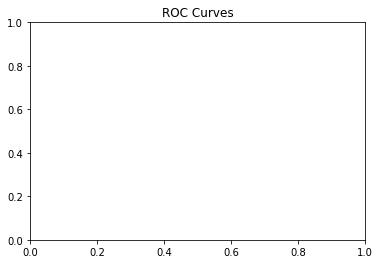

In [51]:
# ROC curve 시각화
Labels = np.array([0, 1])
y_true = np.repeat(Labels, [30, 30], axis=0)
pred = TEST_Prediction[:,0]

skplt.metrics.plot_roc(y_true, pred)
plt.show()

In [39]:
# 다음과 같이 Back-bone model만 수정할 수 있다.
Model = tf.keras.applications.VGG16(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)

Model = tf.keras.applications.ResNet101V2(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)

Model = tf.keras.applications.ResNet101V2(include_top=False,
    weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)

https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=ko

# GradCam visualization 시각화 Heatmap

In [56]:
import PIL

def grad_cam(model, img, layer_name="conv4_block6_out", label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = tf.keras.Model(inputs=[model.inputs], outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap), predictions

def grad_camAll(model, img, layer_name="conv4_block6_out", blockSize=7, label_name=None, category_id=None):
    img_tensor = np.expand_dims(img, axis=0)
    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img_tensor)
        if category_id == None:
            category_id = np.argmax(predictions[0])
        if label_name:
            print(label_name[category_id])
        output = predictions[:, category_id]
        grads = gtape.gradient(output, conv_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    res = sp.ndimage.zoom(conv_output[0], (224/blockSize, 224/blockSize, 1), order=2)   
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, res), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return np.squeeze(heatmap)

def show_imgwithheat(img_path, heatmap, alpha=0.4, return_array=False):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = PIL.Image.fromarray(superimposed_img)  
    display(imgwithheat)

    if return_array:
        return superimposed_img

In [69]:
# CAM Generator
CAM_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = 1,
    shuffle = False,
    class_mode='binary')

Found 60 images belonging to 2 classes.


In [70]:
DeepLearning.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# layer_name 설정: conv2d_38

In [71]:
for Iterator in range(0, 20):
    Image, Label = CAM_GENERATOR.next()
    Image = Image[0]
    FileName = CAM_GENERATOR.filenames[Iterator]
    # Final Layer
    HEATMAP1, pred1 = grad_cam(model = DeepLearning, img = Image, layer_name = 'block5_conv3', category_id=0)
    
    heatmap1 = cv2.resize(HEATMAP1, (Image.shape[1], Image.shape[0]))
    heatmap1 = (heatmap1*255).astype("uint8")
    heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)

    fig, ax = plt.subplots( nrows=3, ncols=1 )  # create figure & 1 axis
    fig.set_size_inches(9.0, 3.0)
    ax = plt.subplot(1,3,1)
    ax.imshow(Image)
    ax = plt.subplot(1,3,2)
    ax.imshow(Image)
    ax.imshow(255-heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
    ax = plt.subplot(1,3,3)
    ax.imshow(Image)
    ax.imshow(heatmap1, cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

    plt.subplots_adjust(left = 0.06, wspace = 0.25, hspace = 0.1, bottom = 0.025, top = 0.975)
    pred=round(pred1.numpy()[0][0],3)
    HeatImage = "HEATMAP/0420_"+CAM_GENERATOR.filenames[Iterator].split('\\')[1] + "^" + str(round(pred, 4)) + ".jpg"
    plt.savefig(HeatImage.strip(), bbox_inches = 'tight')
    plt.close()
    plt.cla()
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [ ]:
for Iterator in range(0, 5):
    Image, Label = CAM_GENERATOR.next()
    Image = Image[0]
    FileName = CAM_GENERATOR.filenames[Iterator]

    LayerNames = ['conv1_conv', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
    Heatmaps = []
    for LayerIDX in range(0, len(LayerNames)):
        HEATMAP1, pred1 = grad_cam(model = MODEL, img = Image, layer_name = LayerNames[LayerIDX], category_id=0)
        heatmap1 = cv2.resize(HEATMAP1, (img_width, img_height))
        heatmap1 = (heatmap1*255).astype("uint8")
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
        Heatmaps.append(heatmap1)


    fig, ax = plt.subplots( nrows=3, ncols=2 )  # create figure & 1 axis
    fig.set_size_inches(9.0, 3.0)
    ax = plt.subplot(2,3,1)
    ax.imshow(Image)
    ax = plt.subplot(2,3,2)
    ax.imshow(Image)
    ax.imshow(255-Heatmaps[0], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
    ax = plt.subplot(2,3,3)
    ax.imshow(Image)
    ax.imshow(255-Heatmaps[1], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )

    ax = plt.subplot(2,3,4)
    ax.imshow(Image)
    ax.imshow(255-Heatmaps[2], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
    ax = plt.subplot(2,3,5)
    ax.imshow(Image)
    ax.imshow(255-Heatmaps[3], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )
    ax = plt.subplot(2,3,6)
    ax.imshow(Image)
    ax.imshow(255-Heatmaps[4], cmap=plt.cm.jet, alpha=0.3, interpolation='nearest' )


    plt.subplots_adjust(left = 0.06, wspace = -0.58, hspace = 0.3, bottom = 0.025, top = 0.975)
    pred=round(pred1.numpy()[0][0],3)
    HeatImage = "HEATMAP/6_"+CAM_GENERATOR.filenames[Iterator].split('\\')[1] + "^" + str(round(pred, 4)) + ".jpg"
    plt.savefig(HeatImage.strip(), bbox_inches = 'tight')
    plt.close()
    plt.cla()
    plt.clf()
    del Image